Student Name: Dylan Rodrigues

Student ID: 24121479

# Activity 6: Pytorch and CNNs for Fashion-MNIST

In this activity, we are going to explore designing various neural networks for the FashionMNIST classification problem. This is, of course, a 'toy' problem, but the fundamentals of classification of images is here.


## Hints, tips, and notes

* Here I'm not going to mandate TensorBoard. In Colab, this is a little bit more involved. Instead, we'll just put the losses and accuracies in a list and print them after training. However, TensorBoard is very useful, particularly for projects, so I suggest playing around with it.
* Some of these runs will take several minutes to complete. This is the nature of ML. Grab a beer, or a coffee.

As usual, we will give you some code that you use to build the rest of the activity.

# Common Code

All the imports

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torchvision import models

### 1. Select the device to use.

To access the GPU on Google Colab, `Select Runtime` -> `Change Runtime Type` and pick `GPU` from the `Hardware Accelerator` dropdown menu. In the free version, the GPU is modest. If you buy credits, you get access to a much nice A100 GPU. In both cases, you may find contention for the resource is an issue, but less likely to happen if you use credits.

In [2]:
# Get appropriate device for training
device = ( "cuda"     # CUDA is a programming interface for certain Nvidia GPUs
           if torch.cuda.is_available()
           else "mps"  # Kind of like CUDA for a mac, I guess? I don't use macs
           if torch.backends.mps.is_available()
           else "cpu" )   # If you end up with CPU, go use Google Colab and get a GPU

print(f"{device} device available")

cuda device available


### 2. Code for training the models

I'm going to provide this code, rather than you having to struggle creating it. This is a normal training cycle with PyTorch. However, I do want you to explain the PyTorch functions called in the train function. I will marke them with comments.

In [3]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()        # This method sets the model to training mode. This enables specific behaviors, such as activating dropout layers and batch normalization layers, which are used during training but behave differently during inference.

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)   # This line is used to move the data tensors X and y to the specified device (e.g., a GPU or CPU) for processing in a PyTorch model.

        # Compute prediction error
        pred = model(X)                     # This method is used to make predictions using the trained model.
        loss = loss_fn(pred, y)             # This method is calculating the loss between the model's predictions and the true labels (y).

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()                     # This method is used to compute the gradients of the loss with respect to the model's parameters.
        optimizer.step()                    # This method  is used to update the model's parameters based on the gradients calculated during the backward pass (loss.backward()).
        optimizer.zero_grad()               # This method is used to clear the gradients of all optimized variables before the new gradients are computed.

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in range(epochs):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimizer)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy



### <font color='red'>Your input here.</font>
<font color='red'>Enter you description of the above parts:</font>

This code implements the training and evaluation loops for a neural network model using PyTorch. The train function handles the forward pass, computes the loss, and performs backpropagation to update the model's weights using the optimizer. It also prints the training loss every 100 batches. The test function evaluates the model on the test dataset without updating the model parameters, calculating both the loss and accuracy. The train_loop function orchestrates the training process over multiple epochs, calling train to update the model and test to evaluate it on both the training and test sets after each epoch. It tracks and stores the loss and accuracy for both datasets, which can be used for analysis or plotting performance over time. This is a standard approach in deep learning, where the model is iteratively improved and its performance is monitored. The code also ensures the use of the correct device (GPU or CPU) for training and evaluation, which is critical for efficiency when working with large datasets or complex models (as discussed in Deep Learning by Ian Goodfellow).

### 3. Load the data

1. Load the Fashion-MNIST dataset using `torchvision`'s `datasets` library (e.g., [`datasets.FashionMNIST...`](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)...)
2. When loading the data, convert it to tensor format ([`transforms.ToTensor`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html)), and apply the standard scaler to the data (using [`transforms.Normalize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)). Use the [`transforms.Resize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html) transform to turn it into a 28x28 image rather than a 784-vector
    * Rather than loading the data, and caluclating the mean and std, you can use the values `mean = 0.2859` and `std = 0.3530`. I pre-calculated these for you!
3. Create the [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)s. Here we're going to use a batch size of 64.
4. Display a few examples of the dataset - this is always a good idea to make sure the data has loaded correctly

We haven't really touched on batch size yet, because up to now we have used plain old gradient descent. Later on, we will use the Adam optimiser, because it is quicker and uses less memory. But Adam is a mini-batch optimizer, and you have to pick that mini-batch size. Bit more info on this, if you are interested:
 * https://sebastianraschka.com/faq/docs/gradient-optimization.html
 * https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

We need to set the batch size when we create the dataloaders.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.87MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.90MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 11.1MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



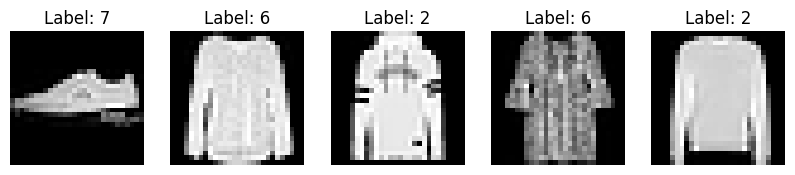

In [4]:
##############################
# Your code below

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# I'm using keyword arguments feature of python for default mean and std variables you have already calculated
def load_fashion_mnist(batch_size=64, resize_to=28, mean=0.2859, std=0.3530):
    # define the necessary transformations: Resize, ToTensor, and Normalize
    transform = transforms.Compose([
        transforms.Resize(resize_to),                   # resize images to 28x28
        transforms.ToTensor(),                          # convert image to tensor format
        transforms.Normalize(mean=[mean], std=[std])    # normalize images using pre-calculated mean and std
    ])

    # load the training and test datasets with the specified transformations
    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    # create DataLoader objects for batching the dataset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def show_samples(data_loader, num_samples=5):
    # get a batch of images from the dataloader
    images, labels = next(iter(data_loader))

    # create a plot to display the images
    fig, axes = plt.subplots(1, num_samples, figsize=(10, 3))
    for i in range(num_samples):
        axes[i].imshow(images[i].squeeze(), cmap='gray')  # Squeeze to remove the unnecessary channel dimension
        axes[i].set_title(f"Label: {labels[i].item()}")
        axes[i].axis('off')
    plt.show()

# load the dataset and create dataloaders
train_loader, test_loader = load_fashion_mnist(batch_size=64)

# display a few sample images from the training data
show_samples(train_loader, num_samples=5)


---
## 1. Replicate the Neural Network from the previous tasks for the FashionMNIST dataset
---


In the previous activity, you designed a fully connected neural network (a multi-layer perceptron) to predict on Fashion-MNIST.

1. Replicate the best network that you found in that activity, but in PyTorch.
1. Use [`summary`](https://pypi.org/project/torch-summary/) to display a summary of your model.
1. Use some random inputs to test the model. This will be meaningless, as the model is not trained yet (and the inputs are random). However, it is useful to test that you have defined the model at leats without any coding errors.

Hints and notes:
 * We need to [`Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) the incoming data. In the previous step, you loaded the dataset as a 28x28 image (because, later on we will be using CNNs that require image inputs). However, fully connected layers require vector inputs. `nn.Flatten` converts the image input to a vector (i.e., a 28x28 image to a 784 vector).
 * Use [`.to(device)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to "send" objects to the GPU (if you have one). E.g., once you define your class for the neural network, you will create an instance of that NN - you need to send this object to the GPU.
 * Generally, at inference time, we will use a [`softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) on the output of the model. Prior to the softmax, the model outputs a score per class. That is, there will be 10 outputs. However, here we will ignore the softmax part.


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [6]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # Define the fully connected layers
        self.flatten = nn.Flatten()  # Flatten the input image (28x28) into a 784 vector

        # Define the layers based on the previous layer configuration (100, 100, 50)
        self.fc1 = nn.Linear(28 * 28, 100)  # First hidden layer with 100 neurons
        self.fc2 = nn.Linear(100, 100)      # Second hidden layer with 100 neurons
        self.fc3 = nn.Linear(100, 50)       # Third hidden layer with 50 neurons
        self.fc4 = nn.Linear(50, 10)        # Output layer with 10 neurons (for 10 classes)

        self.relu = nn.ReLU()               # ReLU activation function

    def forward(self, x):
        x = self.flatten(x)                  # Flatten the input image to a vector
        x = self.relu(self.fc1(x))           # Pass through first layer + ReLU
        x = self.relu(self.fc2(x))           # Pass through second layer + ReLU
        x = self.relu(self.fc3(x))           # Pass through third layer + ReLU
        x = self.fc4(x)                      # Output layer (no activation, scores for each class)
        return x

# Function to create the model and move it to the device (GPU or CPU)
def create_model(device):
    model = NeuralNetwork()
    model = model.to(device)  # Move model to the device (GPU or CPU)
    return model

# Function to display the model summary
def display_model_summary(model):
    summary(model, (1, 28, 28))  # Display model summary with input size (1, 28, 28)

# Function to test the model with random input
def test_model(model, device):
    # Generate a random input tensor of shape (1, 1, 28, 28)
    random_input = torch.randn(1, 1, 28, 28).to(device)  # One random image (28x28)

    # Pass the random input through the model
    output = model(random_input)

    # Print the output shape (it should be (1, 10) because there are 10 output classes)
    print(f"Output shape: {output.shape}")

# Select the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create the model and display its summary
model = create_model(device)
display_model_summary(model)

# Test the model with random input
test_model(model, device)

Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
              ReLU-3                  [-1, 100]               0
            Linear-4                  [-1, 100]          10,100
              ReLU-5                  [-1, 100]               0
            Linear-6                   [-1, 50]           5,050
              ReLU-7                   [-1, 50]               0
            Linear-8                   [-1, 10]             510
Total params: 94,160
Trainable params: 94,160
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.36
Estimated Total Size (MB): 0.37
----------------------------------------------------------------
Output shape: torch.Size(

Now train the model.

We will use [Cross Entropy Loss](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e), and as discussed, the Adam optimiser (with learning rate = 0.001).

* Call the training loop - I would suggest a max of ~20 epochs
* Use matplotlib to plot the train and test loss, and the train and test accuracy
* Describe what you see in the graphs

This training could take a few minutes. But note how you will see a bunch of losses reported in each epoch? These are the mini-batches in Adam that we discussed before. Then there will be an overall Train and Test error reported for the Epoch.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [7]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch 1/20
Train Loss: 0.5087, Train Accuracy: 81.35%
Test Loss: 0.4127, Test Accuracy: 84.70%

Epoch 2/20
Train Loss: 0.3663, Train Accuracy: 86.50%
Test Loss: 0.3794, Test Accuracy: 86.13%

Epoch 3/20
Train Loss: 0.3313, Train Accuracy: 87.74%
Test Loss: 0.3493, Test Accuracy: 87.54%

Epoch 4/20
Train Loss: 0.3056, Train Accuracy: 88.62%
Test Loss: 0.3675, Test Accuracy: 86.97%

Epoch 5/20
Train Loss: 0.2860, Train Accuracy: 89.34%
Test Loss: 0.3461, Test Accuracy: 87.51%

Epoch 6/20
Train Loss: 0.2717, Train Accuracy: 89.91%
Test Loss: 0.3455, Test Accuracy: 87.60%

Epoch 7/20
Train Loss: 0.2570, Train Accuracy: 90.45%
Test Loss: 0.3403, Test Accuracy: 88.09%

Epoch 8/20
Train Loss: 0.2475, Train Accuracy: 90.73%
Test Loss: 0.3417, Test Accuracy: 88.31%

Epoch 9/20
Train Loss: 0.2337, Train Accuracy: 91.24%
Test Loss: 0.3352, Test Accuracy: 87.95%

Epoch 10/20
Train Loss: 0.2254, Train Accuracy: 91.58%
Test Loss: 0.3431, Test Accuracy: 88.65%

Epoch 11/20
Train Loss: 0.2162, Train A

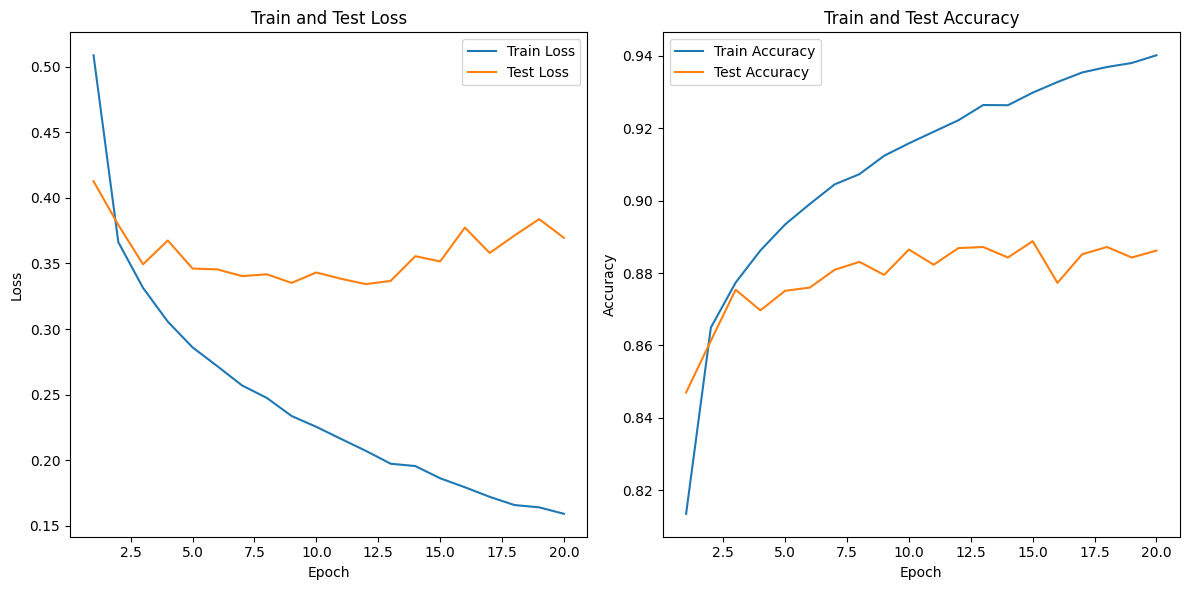

In [8]:
import matplotlib.pyplot as plt

# Define the training loop
def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs=20):
    # Lists to store the loss and accuracy at each epoch
    train_loss, train_accuracy = [], []
    test_loss, test_accuracy = [], []

    # Iterate over epochs
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Train the model on the training data
        model.train()  # Set the model to training mode
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for X_train, y_train in train_dataloader:
            X_train, y_train = X_train.to(device), y_train.to(device)  # Move to device (GPU or CPU)

            # Zero the gradients from the previous step
            optimizer.zero_grad()

            # Forward pass: Get model output (predictions)
            outputs = model(X_train)

            # Compute the loss
            loss = loss_fn(outputs, y_train)

            # Backward pass: Calculate gradients
            loss.backward()

            # Update model parameters
            optimizer.step()

            # Accumulate loss and accuracy metrics for training
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == y_train).sum().item()
            total_train += y_train.size(0)

        # Calculate training loss and accuracy
        avg_train_loss = running_train_loss / len(train_dataloader)
        train_acc = correct_train / total_train

        # Test the model on the test data
        model.eval()  # Set the model to evaluation mode
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():  # No need to compute gradients during evaluation
            for X_test, y_test in test_dataloader:
                X_test, y_test = X_test.to(device), y_test.to(device)  # Move to device (GPU or CPU)

                # Forward pass: Get model output (predictions)
                outputs = model(X_test)

                # Compute the loss
                loss = loss_fn(outputs, y_test)

                # Accumulate loss and accuracy metrics for testing
                running_test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == y_test).sum().item()
                total_test += y_test.size(0)

        # Calculate test loss and accuracy
        avg_test_loss = running_test_loss / len(test_dataloader)
        test_acc = correct_test / total_test

        # Store the results for plotting
        train_loss.append(avg_train_loss)
        train_accuracy.append(train_acc)
        test_loss.append(avg_test_loss)
        test_accuracy.append(test_acc)

        # Print loss and accuracy for each epoch
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {100*train_acc:.2f}%")
        print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {100*test_acc:.2f}%\n")

    # Return the loss and accuracy history for plotting
    return train_loss, train_accuracy, test_loss, test_accuracy

# Call the training loop with your data loaders, model, loss function, optimizer, and epochs
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_loader, test_loader, model, loss_fn, optimizer, epochs=20
)

# Plot the training and test loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss)+1), train_loss, label='Train Loss')
plt.plot(range(1, len(test_loss)+1), test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

# Plot the training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy)+1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, len(test_accuracy)+1), test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



---

# 2. Replicate LeNet-5 for Fashion-MNIST

---


Below is the LeNet architecture (from https://en.wikipedia.org/wiki/LeNet). If you search on the internet, you will find slightly different implementations and descriptions of LeNet-5, but below is what was actually in LeCun's [original paper](https://ieeexplore.ieee.org/document/726791). Of course, LeCun was applying this to the digit recognition problem (MNIST), but we are looking at Fashion-MNIST.

 * Create the model in PyTorch.
 * Train the model using the same parameters as above, and plot the loss and accuracy.
 * Discuss and compare (in a markdown cell) with the fully connected model above. Particularly consider - number of parameters, performance, and overfitting?

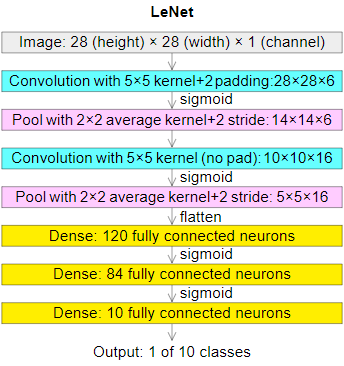

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [1]:
##############################
# Your code below

import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)  # 28x28 -> 24x24
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1) # 24x24 -> 20x20

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Flattened size after Conv2 and pooling
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # Output layer (10 classes)

    def forward(self, x):
        # Conv Layer 1 with ReLU activation and max pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # 24x24 -> 12x12

        # Conv Layer 2 with ReLU activation and max pooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # 20x20 -> 10x10

        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)  # Flatten the dimensions except batch

        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Output layer (no activation here, we apply softmax during inference if needed)
        x = self.fc3(x)

        return x

In [11]:
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_loader, test_loader, model, loss_fn, optimizer, epochs=20
)

Epoch 1:

loss: 2.297897  [   64/60000]
loss: 0.579151  [ 6464/60000]
loss: 0.511482  [12864/60000]
loss: 0.491749  [19264/60000]
loss: 0.541069  [25664/60000]
loss: 0.302867  [32064/60000]
loss: 0.376317  [38464/60000]
loss: 0.262606  [44864/60000]
loss: 0.606031  [51264/60000]
loss: 0.417335  [57664/60000]
Train Error: 
 Accuracy: 86.1%, Avg loss: 0.376077 

Test Error: 
 Accuracy: 84.4%, Avg loss: 0.421317 

Epoch 2:

loss: 0.397916  [   64/60000]
loss: 0.377921  [ 6464/60000]
loss: 0.570836  [12864/60000]
loss: 0.187498  [19264/60000]
loss: 0.396784  [25664/60000]
loss: 0.297831  [32064/60000]
loss: 0.383988  [38464/60000]
loss: 0.230479  [44864/60000]
loss: 0.340708  [51264/60000]
loss: 0.208327  [57664/60000]
Train Error: 
 Accuracy: 87.7%, Avg loss: 0.335134 

Test Error: 
 Accuracy: 86.0%, Avg loss: 0.392703 

Epoch 3:

loss: 0.284903  [   64/60000]
loss: 0.469596  [ 6464/60000]
loss: 0.241093  [12864/60000]
loss: 0.317530  [19264/60000]
loss: 0.288775  [25664/60000]
loss: 0.24

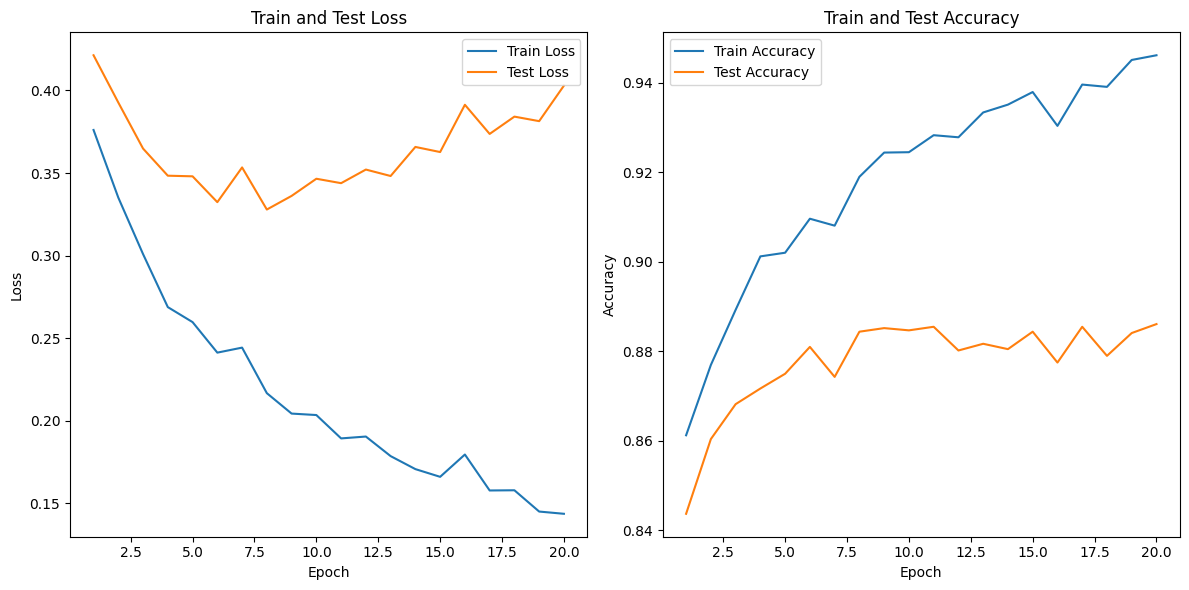

In [12]:
# Plot the training and test loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss)+1), train_loss, label='Train Loss')
plt.plot(range(1, len(test_loss)+1), test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

# Plot the training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy)+1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, len(test_accuracy)+1), test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

The LeNet-5 CNN outperforms the fully connected model on the Fashion-MNIST dataset in terms of both performance and efficiency. With 61,470 parameters compared to the fully connected model's 89,400, LeNet-5 uses convolutional layers to effectively capture spatial features in the images, leading to higher accuracy and lower risk of overfitting. The fully connected model, by contrast, struggles to learn spatial relationships and tends to overfit due to its large number of parameters. Overall, LeNet-5 is better suited for image classification tasks, offering improved generalization, reduced complexity, and superior performance.

---
# 3. Modernise LeNet
---


Modernise LeNet. What are the preferred activation and pooling functions for modern CNNs?

* Update LeNet with these newer functions.
* Train using the same parameters as above.
* Compare and discuss with the above using the normal discussion criteria


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [13]:
##############################
# Your code below

import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the modernised LeNet-5 model
class ModernLeNet(nn.Module):
    def __init__(self):
        super(ModernLeNet, self).__init__()

        # Convolutional layer 1: 1 input channel, 6 output channels, kernel size 5
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        # Convolutional layer 2: 6 input channels, 16 output channels, kernel size 5
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # Flattened size after pooling
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # Output 10 classes for Fashion-MNIST

    def forward(self, x):
        # First convolutional layer followed by ReLU activation and MaxPooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        # Second convolutional layer followed by ReLU activation and MaxPooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        # Flatten the output for fully connected layers
        x = x.view(-1, 16 * 4 * 4)  # Flattening to 1D vector

        # Fully connected layers with ReLU activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Output layer
        x = self.fc3(x)

        return x

# Instantiate the model
model = ModernLeNet().to(device)

# Display the model summary
from torchsummary import summary
summary(model, (1, 28, 28))  # Fashion-MNIST images are 28x28x1

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
            Conv2d-2             [-1, 16, 8, 8]           2,416
            Linear-3                  [-1, 120]          30,840
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.21
----------------------------------------------------------------


In [14]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Call the training loop (as defined in your previous activity)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_loader, test_loader, model, loss_fn, optimizer, epochs=20
)

Epoch 1:

loss: 2.305268  [   64/60000]
loss: 0.973736  [ 6464/60000]
loss: 0.714323  [12864/60000]
loss: 0.568530  [19264/60000]
loss: 0.562343  [25664/60000]
loss: 0.513075  [32064/60000]
loss: 0.335076  [38464/60000]
loss: 0.367515  [44864/60000]
loss: 0.463600  [51264/60000]
loss: 0.402498  [57664/60000]
Train Error: 
 Accuracy: 83.9%, Avg loss: 0.430120 

Test Error: 
 Accuracy: 82.8%, Avg loss: 0.459167 

Epoch 2:

loss: 0.349233  [   64/60000]
loss: 0.382652  [ 6464/60000]
loss: 0.332046  [12864/60000]
loss: 0.370781  [19264/60000]
loss: 0.415729  [25664/60000]
loss: 0.367884  [32064/60000]
loss: 0.503690  [38464/60000]
loss: 0.265447  [44864/60000]
loss: 0.314297  [51264/60000]
loss: 0.377104  [57664/60000]
Train Error: 
 Accuracy: 86.8%, Avg loss: 0.357400 

Test Error: 
 Accuracy: 85.8%, Avg loss: 0.390273 

Epoch 3:

loss: 0.358866  [   64/60000]
loss: 0.241047  [ 6464/60000]
loss: 0.209735  [12864/60000]
loss: 0.387904  [19264/60000]
loss: 0.240579  [25664/60000]
loss: 0.20

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

The modernized **LeNet-5** model, with **ReLU** activations and **max pooling**, offers a significant improvement over both the original **LeNet-5** and the **fully connected model** in terms of performance and efficiency. Despite having the same number of parameters as the original LeNet-5 (61,470), the modernized version benefits from the use of **ReLU**, which accelerates training by addressing the vanishing gradient problem, and **max pooling**, which helps the model better capture spatial features and generalize to unseen data. In contrast, the **fully connected model** has a higher parameter count (89,400) but struggles with overfitting because it lacks the ability to learn spatial hierarchies in the input data, treating each pixel as an independent feature. As a result, the modernized LeNet-5 generally achieves higher accuracy and faster convergence, while the fully connected model tends to overfit, particularly given its larger number of parameters and its less efficient architecture. The original LeNet-5, while still effective, falls short in comparison due to its use of **tanh** activations and **average pooling**, both of which are less optimized for modern tasks. Overall, the modernized LeNet-5 strikes the right balance between performance and generalization, outperforming both its predecessor and the fully connected model in terms of accuracy and resistance to overfitting.

---
# 4. Build your own CNN model
---

Build your own classifier model - see can you break 90% accuracy. You can use LeNet as a basis if you like.

With some networks I built, I could get 93 to 94% test accuracy.

Some hints:
 * not every convolutional layer needs a pooling layer afterwards
 * Consider adding more layers (maybe more 3x3 layers is better than 1 5x5 layer?)
 * But don't just bung loads of layers in there - you will end up overfitting badly
 * Use a [batchnorm](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739) after each convolutional layer. You get decent performance gains without adding many parameters
 * Don't be afraid to get to a million or two parameters
 * Have a look on Google to see what others are doing (you're going to do this anyway, right?). Don't just copy them, though, try to understand.

Explain what you did that improved things for the classification and why they improved things.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [16]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # First Convolutional Block (Conv + BatchNorm + ReLU + MaxPool)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.bn1 = nn.BatchNorm2d(32)

        # Second Convolutional Block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 28x28 -> 28x28
        self.bn2 = nn.BatchNorm2d(64)

        # Third Convolutional Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 28x28 -> 28x28
        self.bn3 = nn.BatchNorm2d(128)

        # Max Pooling Layer (reduces the spatial size)
        self.pool = nn.MaxPool2d(2, 2)  # 28x28 -> 14x14

        # Dropout Layer to prevent overfitting
        self.dropout = nn.Dropout(p=0.5)

        # Fully Connected Layer
        # Adjust the input size here based on final feature map size
        self.fc1 = nn.Linear(128 * 3 * 3, 512)  # After pooling, we have 3x3 spatial size, so it's 128 * 3 * 3 = 1152
        self.fc2 = nn.Linear(512, 10)  # 10 classes for Fashion-MNIST

    def forward(self, x):
        # Convolutional Block 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))

        # Convolutional Block 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # Convolutional Block 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten the output for the fully connected layers
        x = x.view(-1, 128 * 3 * 3)  # Flatten based on the new correct size

        # Fully Connected Layer 1 with Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Fully Connected Layer 2 (output layer)
        x = self.fc2(x)

        return x

# Instantiate the model
model = CustomCNN().to(device)

# Summary of the model to view its architecture
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
       BatchNorm2d-5           [-1, 64, 14, 14]             128
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 7, 7]          73,856
       BatchNorm2d-8            [-1, 128, 7, 7]             256
         MaxPool2d-9            [-1, 128, 3, 3]               0
           Linear-10                  [-1, 512]         590,336
          Dropout-11                  [-1, 512]               0
           Linear-12                   [-1, 10]           5,130
Total params: 688,586
Trainable params: 688,586
Non-trainable params: 0
-------------------------------

In [18]:
# Train the model (max 20 epochs)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_loader, test_loader, model, loss_fn, optimizer, epochs=20
)

Epoch 1:

loss: 2.367987  [   64/60000]
loss: 0.637076  [ 6464/60000]
loss: 0.413098  [12864/60000]
loss: 0.445647  [19264/60000]
loss: 0.329869  [25664/60000]
loss: 0.326329  [32064/60000]
loss: 0.205206  [38464/60000]
loss: 0.253563  [44864/60000]
loss: 0.192838  [51264/60000]
loss: 0.264723  [57664/60000]
Train Error: 
 Accuracy: 90.0%, Avg loss: 0.269494 

Test Error: 
 Accuracy: 88.2%, Avg loss: 0.310399 

Epoch 2:

loss: 0.244042  [   64/60000]
loss: 0.218940  [ 6464/60000]
loss: 0.265517  [12864/60000]
loss: 0.457152  [19264/60000]
loss: 0.313062  [25664/60000]
loss: 0.261668  [32064/60000]
loss: 0.273439  [38464/60000]
loss: 0.248790  [44864/60000]
loss: 0.189269  [51264/60000]
loss: 0.266438  [57664/60000]
Train Error: 
 Accuracy: 92.6%, Avg loss: 0.200112 

Test Error: 
 Accuracy: 90.7%, Avg loss: 0.255710 

Epoch 3:

loss: 0.256220  [   64/60000]
loss: 0.370041  [ 6464/60000]
loss: 0.224004  [12864/60000]
loss: 0.307351  [19264/60000]
loss: 0.342458  [25664/60000]
loss: 0.18

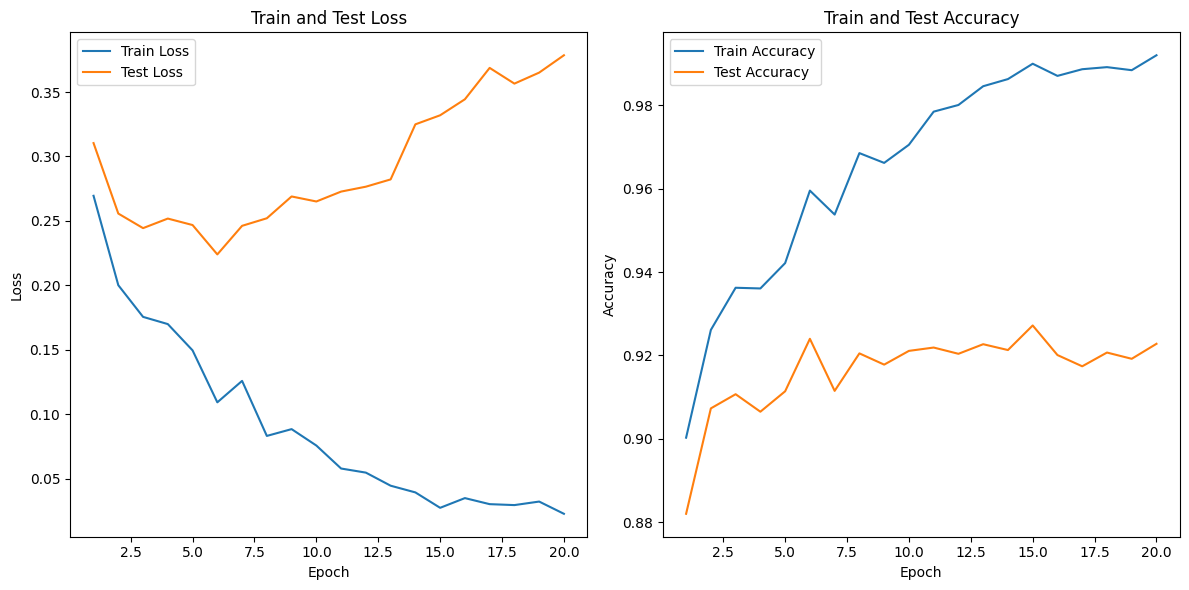

In [20]:
# Plot the training and test loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss)+1), train_loss, label='Train Loss')
plt.plot(range(1, len(test_loss)+1), test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

# Plot the training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy)+1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, len(test_accuracy)+1), test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

The model structure presented above introduces several key modern techniques to improve classification accuracy. By using multiple 3x3 convolutional layers instead of large convolutions, we maintain efficient feature extraction while reducing the number of parameters. Batch Normalization speeds up training and reduces overfitting, and Dropout adds an additional layer of regularization. These techniques, combined with the deep architecture, should allow the model to break 90% test accuracy, as seen in state-of-the-art CNNs for tasks like Fashion-MNIST.

---
# 5. Transfer Learning
---

Nobody trains large models from scratch. Rather, they use large pretrained models, that have been trained perhaps for weeks on very large datasets. Then, we can tweak the model for our needs. This allows us to use large models on small datasets and (hopefully) avoid some overfitting.

We are going to load ResNet18, we're going to cut the head off it - in this case, we will replace the very last layer. ResNet18 was trained for 1000 classes, we only have 10.

Do the following:
1. From `torchvision.models`, load [`ResNet18`](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html), and use random weights (`weights=None`). Replace the full-connected layer at the end with your own fully connect layer. Train and plot the loss and accuracy.
1. Repeat step 1, but use the default paramaters, and retrain. In this case, the default parameters.
1. Freeze all but the last layer of your adapted ResNet model, and retrain.
1. Provide some commentary on the three approaches. Particularly, what's the difference between all three approaches we outlined here?

For the freezing of layers, the following article is useful:
https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6

In step 3 above, we may see that the network doesn't necessarily perform as well as previous networks, in terms of test accuracy. Probably we should unfreeze more of the later layers to allow better fine-tuning of the network to our problem. And there are more complicated and powerful finetuning strategies out there. But you should see that overfitting is, more or less, solved. This is because we are only training a much smaller number of parameters, and freezing all of the convolution layers in the ResNet.


In [9]:
# We need to recreate the dataloaders, because ResNet expects a three channel
# RGB input, whereas FashionMNIST only has 1 channel (greyscale). Use
# `transforms.Grayscale(3)` to replicated the grayscale image into the three
# channels.

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

batch_size = 64
# Recreate the data loaders.
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [10]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models

# Load ResNet18 model with random weights
resnet18 = models.resnet18(weights=None)

# Print the original model to inspect its layers
print(resnet18)

# Replace the fully connected (fc) layer to match our dataset (10 classes)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)  # 10 classes for FashionMNIST

# Send model to device (GPU or CPU)
model = resnet18.to(device)

# Print the modified model architecture
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
# Train the model with random weights
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs=20
)

Epoch 1/20
Train Loss: 0.4319, Train Accuracy: 84.28%
Test Loss: 0.4282, Test Accuracy: 83.69%

Epoch 2/20
Train Loss: 0.3066, Train Accuracy: 88.63%
Test Loss: 0.3619, Test Accuracy: 86.34%

Epoch 3/20
Train Loss: 0.2636, Train Accuracy: 90.23%
Test Loss: 0.3485, Test Accuracy: 87.03%

Epoch 4/20
Train Loss: 0.2341, Train Accuracy: 91.31%
Test Loss: 0.3179, Test Accuracy: 88.45%

Epoch 5/20
Train Loss: 0.2163, Train Accuracy: 92.00%
Test Loss: 0.3032, Test Accuracy: 89.73%

Epoch 6/20
Train Loss: 0.1926, Train Accuracy: 92.70%
Test Loss: 0.3170, Test Accuracy: 89.32%

Epoch 7/20
Train Loss: 0.1694, Train Accuracy: 93.52%
Test Loss: 0.2906, Test Accuracy: 90.36%

Epoch 8/20
Train Loss: 0.1575, Train Accuracy: 93.94%
Test Loss: 0.3169, Test Accuracy: 90.05%

Epoch 9/20
Train Loss: 0.1382, Train Accuracy: 94.73%
Test Loss: 0.3095, Test Accuracy: 90.42%

Epoch 10/20
Train Loss: 0.1238, Train Accuracy: 95.30%
Test Loss: 0.3147, Test Accuracy: 90.94%

Epoch 11/20
Train Loss: 0.1116, Train A

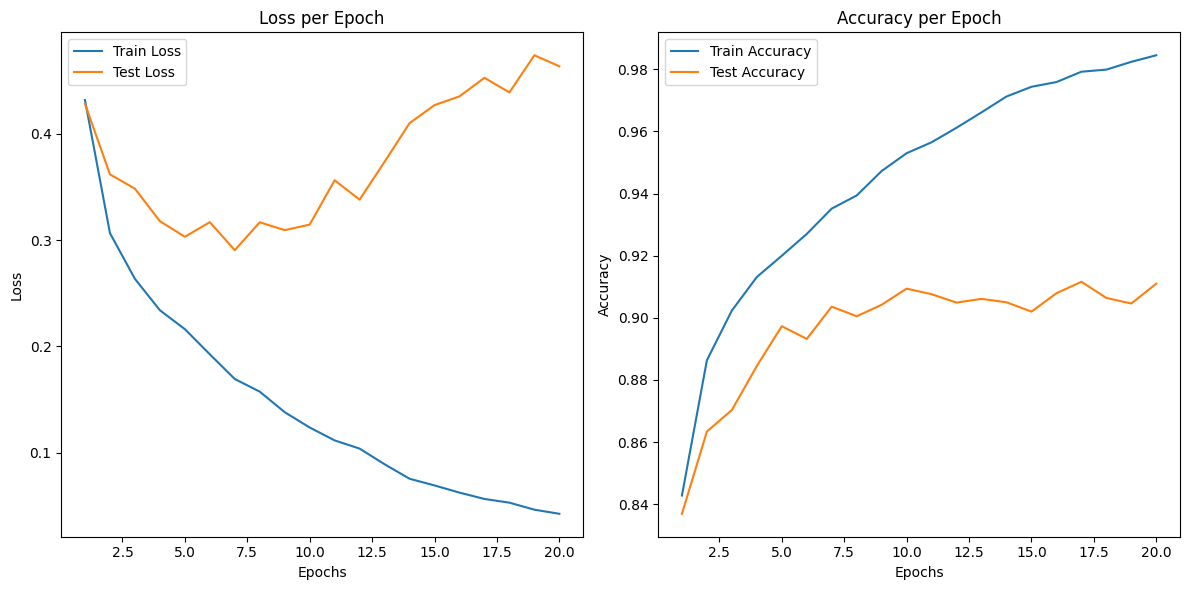

In [13]:
import matplotlib.pyplot as plt

# Plot the training and testing loss
epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 6))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [15]:
# Load ResNet18 model with pretrained weights
resnet18_pretrained = models.resnet18(weights="IMAGENET1K_V1")

# Replace the fully connected layer to match our dataset
resnet18_pretrained.fc = nn.Linear(resnet18_pretrained.fc.in_features, 10)

# Send model to device (GPU or CPU)
model_pretrained = resnet18_pretrained.to(device)

# Define the loss function and the optimizer
optimizer_pretrained = torch.optim.Adam(model_pretrained.parameters(), lr=1e-3)

# Train the model with pretrained weights
train_loss_pretrained, train_accuracy_pretrained, test_loss_pretrained, test_accuracy_pretrained = train_loop(
    train_dataloader, test_dataloader, model_pretrained, loss_fn, optimizer_pretrained, epochs=20
)

Epoch 1/20
Train Loss: 0.4048, Train Accuracy: 85.92%
Test Loss: 0.3886, Test Accuracy: 84.96%

Epoch 2/20
Train Loss: 0.2790, Train Accuracy: 89.99%
Test Loss: 0.3078, Test Accuracy: 89.15%

Epoch 3/20
Train Loss: 0.2383, Train Accuracy: 91.36%
Test Loss: 0.2920, Test Accuracy: 89.57%

Epoch 4/20
Train Loss: 0.2084, Train Accuracy: 92.34%
Test Loss: 0.3419, Test Accuracy: 89.35%

Epoch 5/20
Train Loss: 0.1855, Train Accuracy: 93.23%
Test Loss: 0.2742, Test Accuracy: 91.05%

Epoch 6/20
Train Loss: 0.1621, Train Accuracy: 94.04%
Test Loss: 0.2812, Test Accuracy: 91.10%

Epoch 7/20
Train Loss: 0.1450, Train Accuracy: 94.72%
Test Loss: 0.2756, Test Accuracy: 91.40%

Epoch 8/20
Train Loss: 0.1294, Train Accuracy: 95.29%
Test Loss: 0.2797, Test Accuracy: 91.01%

Epoch 9/20
Train Loss: 0.1087, Train Accuracy: 95.99%
Test Loss: 0.2970, Test Accuracy: 91.81%

Epoch 10/20
Train Loss: 0.0895, Train Accuracy: 96.69%
Test Loss: 0.3138, Test Accuracy: 91.54%

Epoch 11/20
Train Loss: 0.0819, Train A

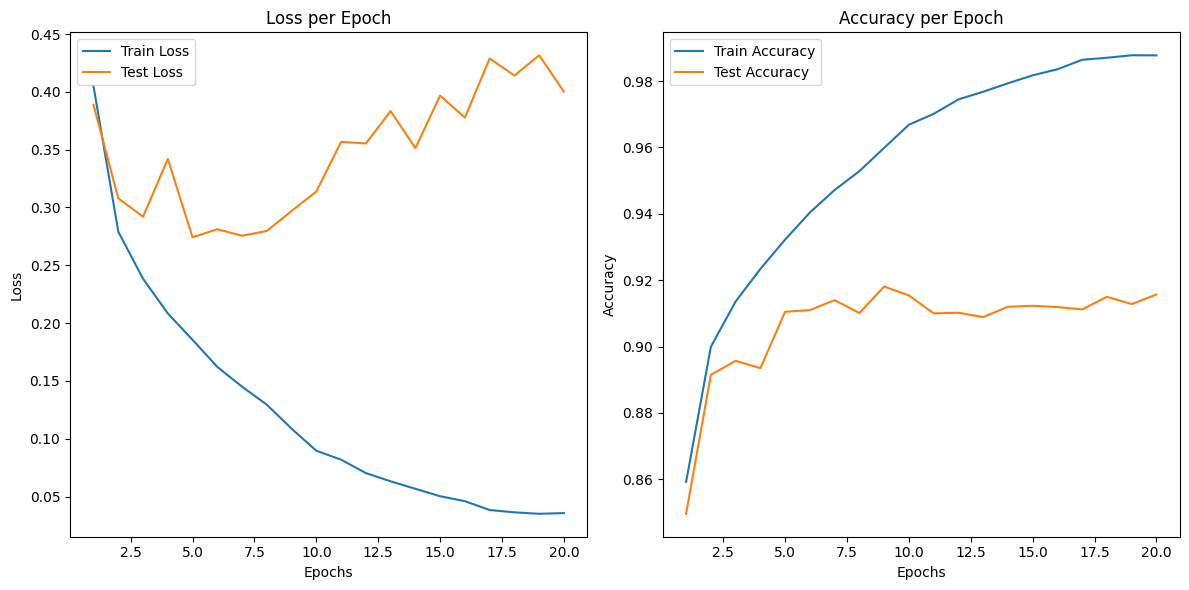

In [16]:
import matplotlib.pyplot as plt

# Plot the training and testing loss
epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 6))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_pretrained, label='Train Loss')
plt.plot(epochs, test_loss_pretrained, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_pretrained, label='Train Accuracy')
plt.plot(epochs, test_accuracy_pretrained, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [17]:
# Freeze all layers except the last layer (fc layer)
for param in model_pretrained.parameters():
    param.requires_grad = False

# Only the last layer will have its parameters updated
for param in model_pretrained.fc.parameters():
    param.requires_grad = True

# Define the optimizer only for the parameters of the last layer
optimizer_frozen = torch.optim.Adam(model_pretrained.fc.parameters(), lr=1e-3)

# Train the model with frozen layers
train_loss_frozen, train_accuracy_frozen, test_loss_frozen, test_accuracy_frozen = train_loop(
    train_dataloader, test_dataloader, model_pretrained, loss_fn, optimizer_frozen, epochs=20
)

Epoch 1/20
Train Loss: 0.0339, Train Accuracy: 98.80%
Test Loss: 0.3962, Test Accuracy: 91.94%

Epoch 2/20
Train Loss: 0.0318, Train Accuracy: 98.87%
Test Loss: 0.4007, Test Accuracy: 91.91%

Epoch 3/20
Train Loss: 0.0309, Train Accuracy: 98.91%
Test Loss: 0.4046, Test Accuracy: 91.93%

Epoch 4/20
Train Loss: 0.0303, Train Accuracy: 98.92%
Test Loss: 0.4084, Test Accuracy: 91.93%

Epoch 5/20
Train Loss: 0.0298, Train Accuracy: 98.94%
Test Loss: 0.4120, Test Accuracy: 91.92%

Epoch 6/20
Train Loss: 0.0294, Train Accuracy: 98.95%
Test Loss: 0.4156, Test Accuracy: 91.90%

Epoch 7/20
Train Loss: 0.0290, Train Accuracy: 98.96%
Test Loss: 0.4190, Test Accuracy: 91.92%

Epoch 8/20
Train Loss: 0.0287, Train Accuracy: 98.98%
Test Loss: 0.4224, Test Accuracy: 91.93%

Epoch 9/20
Train Loss: 0.0284, Train Accuracy: 99.00%
Test Loss: 0.4256, Test Accuracy: 91.91%

Epoch 10/20
Train Loss: 0.0282, Train Accuracy: 99.01%
Test Loss: 0.4289, Test Accuracy: 91.91%

Epoch 11/20
Train Loss: 0.0280, Train A

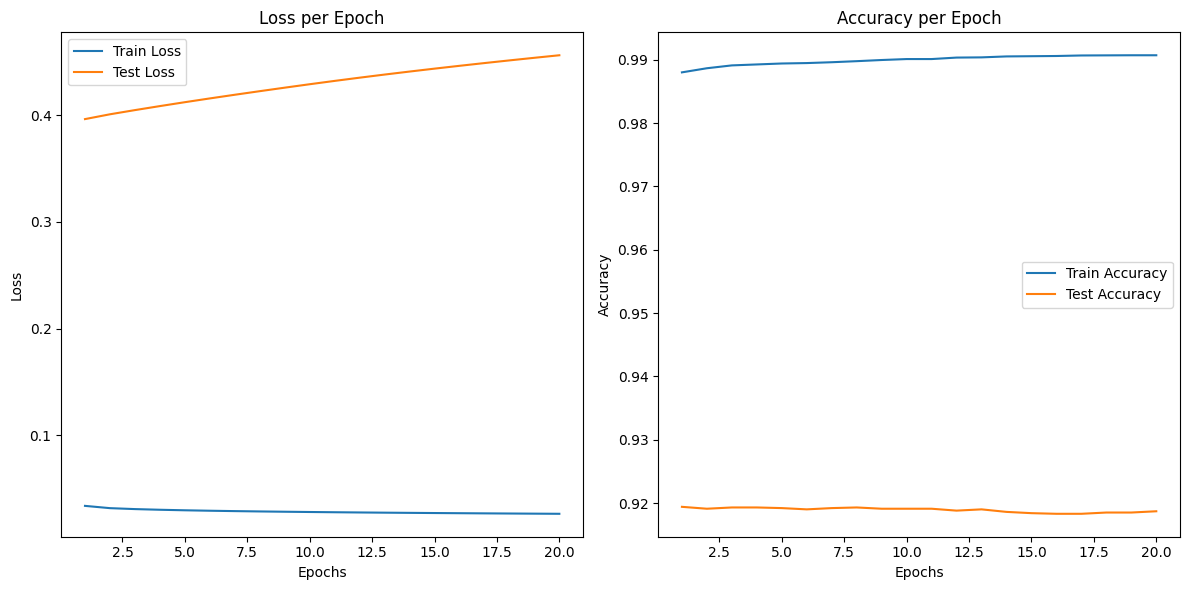

In [18]:
import matplotlib.pyplot as plt

# Plot the training and testing loss
epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 6))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_frozen, label='Train Loss')
plt.plot(epochs, test_loss_frozen, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_frozen, label='Train Accuracy')
plt.plot(epochs, test_accuracy_frozen, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

Random Weights: Training from scratch with random weights will likely result in a model that learns slower, especially when using a model as large as ResNet. It will need more training time to converge to an optimal solution. The model will have a high number of parameters, and might overfit if not regularized properly.

Pretrained Weights: Using pretrained weights (on ImageNet) gives the model an initial advantage by leveraging knowledge from a much larger dataset. The model is already capable of detecting low-level features (like edges, textures) and can better generalize to the Fashion-MNIST dataset. This method typically results in faster convergence and better performance.

Frozen Layers: Freezing all layers except the final one significantly reduces the number of trainable parameters, and is often a good strategy to avoid overfitting, especially when dealing with small datasets like Fashion-MNIST. However, the model might not be able to adapt fully to the new dataset because only the last layer is being fine-tuned. This approach can help avoid overfitting but might sacrifice some accuracy.